In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')


In [2]:
# --- 1. Load the datasets ---
print("--- Loading Datasets ---")
try:
    df_apps = pd.read_csv('googleplaystore (1).csv')
    df_reviews = pd.read_csv('googleplaystore_user_reviews (1).csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure the files are in the correct directory.")
    # Exit or handle the error appropriately if files are not found
    exit()

--- Loading Datasets ---
Datasets loaded successfully.


In [3]:
# --- 2. Initial Data Inspection ---
print("\n--- Initial Data Inspection (df_apps) ---")
print("df_apps shape:", df_apps.shape)
print("\ndf_apps head:")
print(df_apps.head())
print("\ndf_apps info:")
df_apps.info()
print("\ndf_apps describe:")
print(df_apps.describe(include='all'))

print("\n--- Initial Data Inspection (df_reviews) ---")
print("df_reviews shape:", df_reviews.shape)
print("\ndf_reviews head:")
print(df_reviews.head())
print("\ndf_reviews info:")
df_reviews.info()
print("\ndf_reviews describe:")
print(df_reviews.describe(include='all'))


--- Initial Data Inspection (df_apps) ---
df_apps shape: (10841, 13)

df_apps head:
                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0        

In [ ]:
# --- 3. Data Cleaning and Preprocessing for df_apps ---
print("\n--- Cleaning Data (df_apps) ---")

problematic_row = df_apps[df_apps['App'] == 'Life Made WI-FI Touchscreen Photo Frame']
if not problematic_row.empty:
    print(f"\n--- Handling Problematic Row ---")
    print("Problematic row identified:")
    print(problematic_row)
    df_apps = df_apps.drop(df_apps[df_apps['App'] == 'Life Made WI-FI Touchscreen Photo Frame'].index)
    print("Problematic row removed.")
else:
    print("\n--- No Problematic Row 'Life Made WI-FI Touchscreen Photo Frame' found, skipping removal. ---")

print("\n--- Handling Missing Values (df_apps) ---")
print("Missing values before handling:\n", df_apps.isnull().sum())

# Drop rows where 'Rating' is NaN (as it's a key feature for analysis and prediction target)
df_apps.dropna(subset=['Rating'], inplace=True)
print("\nMissing values after dropping rows with NaN 'Rating':\n", df_apps.isnull().sum())

# Fill 'Current Ver' and 'Android Ver' with their mode or 'Varies with device'
for col in ['Current Ver', 'Android Ver']:
    if df_apps[col].isnull().any():
        df_apps[col].fillna(df_apps[col].mode()[0], inplace=True)

# Fill 'Type' NaN with 'Free' (mode)
if df_apps['Type'].isnull().any():
    df_apps['Type'].fillna(df_apps['Type'].mode()[0], inplace=True)

# Fill 'Content Rating' NaN with 'Everyone' (mode)
if df_apps['Content Rating'].isnull().any():
    df_apps['Content Rating'].fillna(df_apps['Content Rating'].mode()[0], inplace=True)

print("\nMissing values after filling:\n", df_apps.isnull().sum())


print("\n--- Cleaning Data Types (df_apps) ---")

# Convert 'Reviews' to numeric
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'], errors='coerce')
print("Reviews column converted to numeric.")




--- Cleaning Data (df_apps) ---

--- No Problematic Row 'Life Made WI-FI Touchscreen Photo Frame' found, skipping removal. ---

--- Handling Missing Values (df_apps) ---
Missing values before handling:
 App               0
Category          0
Rating            0
Reviews           1
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Missing values after dropping rows with NaN 'Rating':
 App               0
Category          0
Rating            0
Reviews           1
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

Missing values after filling:
 App               0
Category          0
Rating            0
Reviews           1
Size              0
Installs          0
Type              0
Price             0
Co

In [8]:
# Convert 'Size' to MB and numeric
def clean_size(x):
	if isinstance(x, str):
		if 'M' in x:
			return x.replace('M', '')
		elif 'k' in x:
			return float(x.replace('k', '')) / 1024
		elif 'Varies with device' in x:
			return np.nan
		else:
			return x
	return x

df_apps['Size'] = df_apps['Size'].apply(clean_size)
df_apps['Size'] = pd.to_numeric(df_apps['Size'], errors='coerce')
df_apps['Size'].fillna(df_apps['Size'].median(), inplace=True)
print("Size column cleaned and converted to numeric (MB).")

# Convert 'Installs' to numeric
def clean_installs(x):
	if isinstance(x, str):
		x = x.replace('+', '')
		x = x.replace(',', '')
	return x

df_apps['Installs'] = df_apps['Installs'].apply(clean_installs)
df_apps['Installs'] = pd.to_numeric(df_apps['Installs'], errors='coerce')
print("Installs column cleaned and converted to numeric.")

# Convert 'Price' to numeric
def clean_price(x):
	if isinstance(x, str):
		return x.replace('$', '')
	return x

df_apps['Price'] = df_apps['Price'].apply(clean_price)
df_apps['Price'] = pd.to_numeric(df_apps['Price'], errors='coerce')
print("Price column cleaned and converted to numeric.")

# Convert 'Last Updated' to datetime, coercing errors to NaT
df_apps['Last Updated'] = pd.to_datetime(df_apps['Last Updated'], errors='coerce')
print("Last Updated column converted to datetime (invalid formats set to NaT).")

# Convert 'Rating' to numeric (already done during dropna, but good to ensure)
df_apps['Rating'] = pd.to_numeric(df_apps['Rating'], errors='coerce')
print("Rating column ensured to be numeric.")

# Display info after cleaning
print("\ndf_apps info after cleaning:")
df_apps.info()


Size column cleaned and converted to numeric (MB).
Installs column cleaned and converted to numeric.
Price column cleaned and converted to numeric.
Last Updated column converted to datetime (invalid formats set to NaT).
Rating column ensured to be numeric.

df_apps info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 9367 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             9367 non-null   object        
 1   Category        9367 non-null   object        
 2   Rating          9367 non-null   float64       
 3   Reviews         9366 non-null   float64       
 4   Size            9367 non-null   float64       
 5   Installs        9366 non-null   float64       
 6   Type            9367 non-null   object        
 7   Price           9366 non-null   float64       
 8   Content Rating  9367 non-null   object        
 9   Genres          9367 non-null   o

In [9]:
# --- 4. Data Cleaning and Preprocessing for df_reviews ---
print("\n--- Handling Missing Values (df_reviews) ---")
print("Missing values before handling:\n", df_reviews.isnull().sum())

# Drop rows with NaN 'Translated_Review' as they don't contribute to sentiment analysis
df_reviews.dropna(subset=['Translated_Review'], inplace=True)
print("\nMissing values after dropping rows with NaN 'Translated_Review':\n", df_reviews.isnull().sum())


--- Handling Missing Values (df_reviews) ---
Missing values before handling:
 App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

Missing values after dropping rows with NaN 'Translated_Review':
 App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64


In [11]:
# --- 5. Merge Datasets ---
print("\n--- Merging Datasets ---")
# Before merging, ensure 'App' column is consistent (strip whitespace, convert to lower case for robustness)
df_apps['App'] = df_apps['App'].str.strip().str.lower()
df_reviews['App'] = df_reviews['App'].str.strip().str.lower()

# Merge based on 'App'
# Using inner merge to keep only apps present in both datasets and that have translated reviews
merged_df = pd.merge(df_apps, df_reviews, on='App', how='inner')
print("Datasets merged successfully. Merged_df shape:", merged_df.shape)
print("\nMerged_df head:")
print(merged_df.head())


--- Merging Datasets ---
Datasets merged successfully. Merged_df shape: (72638, 17)

Merged_df head:
                   App        Category  Rating  Reviews  Size  Installs  Type  \
0  coloring book moana  ART_AND_DESIGN     3.9    967.0  14.0  500000.0  Free   
1  coloring book moana  ART_AND_DESIGN     3.9    967.0  14.0  500000.0  Free   
2  coloring book moana  ART_AND_DESIGN     3.9    967.0  14.0  500000.0  Free   
3  coloring book moana  ART_AND_DESIGN     3.9    967.0  14.0  500000.0  Free   
4  coloring book moana  ART_AND_DESIGN     3.9    967.0  14.0  500000.0  Free   

   Price Content Rating                     Genres Last Updated Current Ver  \
0    0.0       Everyone  Art & Design;Pretend Play   2018-01-15       2.0.0   
1    0.0       Everyone  Art & Design;Pretend Play   2018-01-15       2.0.0   
2    0.0       Everyone  Art & Design;Pretend Play   2018-01-15       2.0.0   
3    0.0       Everyone  Art & Design;Pretend Play   2018-01-15       2.0.0   
4    0.0       E


--- Exploratory Data Analysis (EDA) ---

--- Distribution of App Ratings ---


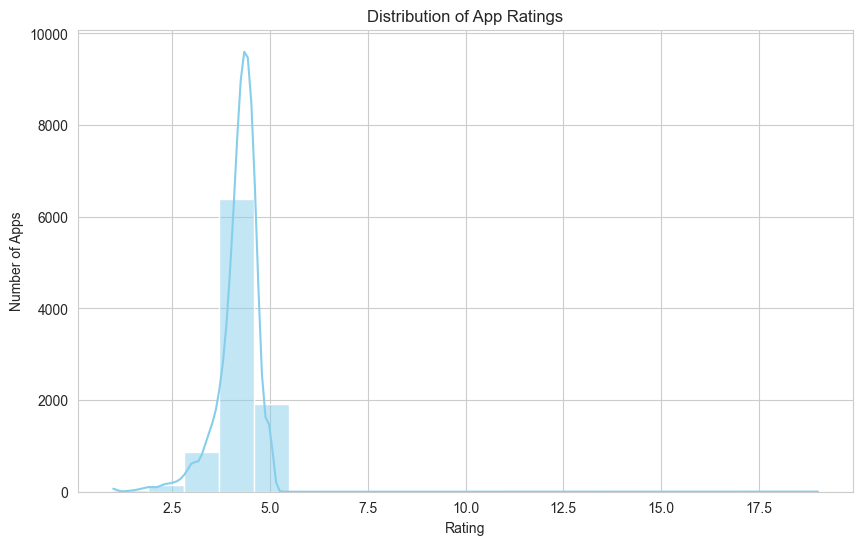

Most apps have ratings between 4.0 and 4.5.


In [12]:
# --- 6. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis (EDA) ---")

# Set aesthetic style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 6.1 Distribution of App Ratings
print("\n--- Distribution of App Ratings ---")
plt.figure(figsize=(10, 6))
sns.histplot(df_apps['Rating'].dropna(), bins=20, kde=True, color='skyblue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Apps')
plt.show()
print("Most apps have ratings between 4.0 and 4.5.")



--- Top Categories by App Count ---


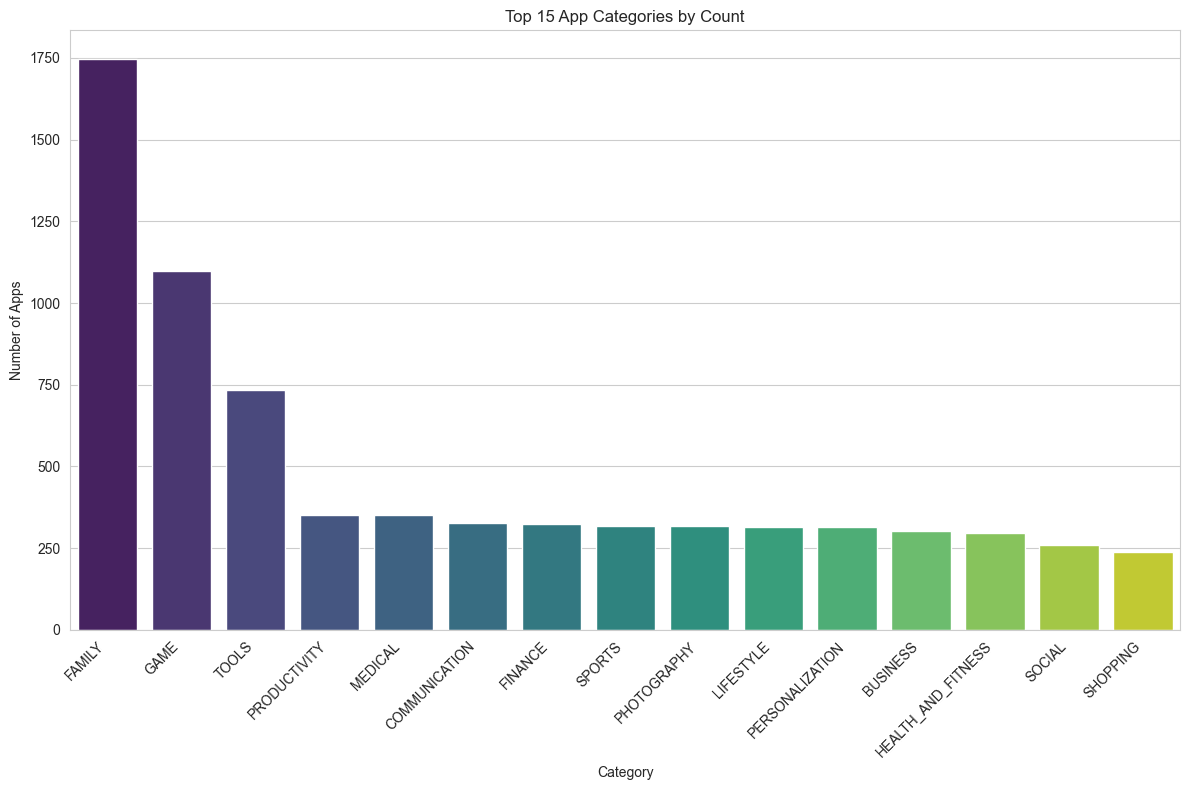

Family and Game categories have the highest number of apps.


In [13]:
# 6.2 Top Categories by App Count
print("\n--- Top Categories by App Count ---")
plt.figure(figsize=(12, 8))
category_counts = df_apps['Category'].value_counts().head(15)
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Top 15 App Categories by Count')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Family and Game categories have the highest number of apps.")



--- Distribution of App Types ---


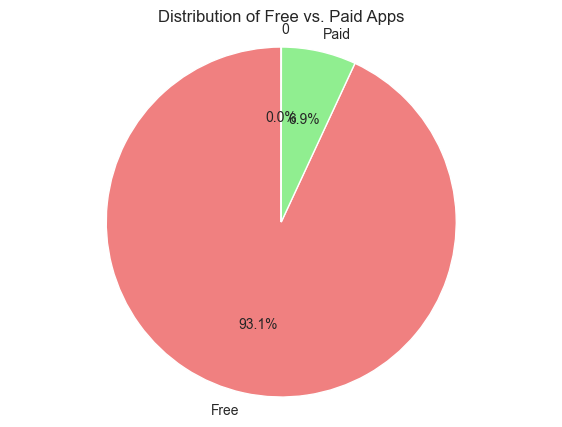

A vast majority of apps on the Play Store are Free.


In [14]:
# 6.3 Distribution of App Types (Free vs. Paid)
print("\n--- Distribution of App Types ---")
plt.figure(figsize=(7, 5))
type_counts = df_apps['Type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Distribution of Free vs. Paid Apps')
plt.axis('equal')
plt.show()
print("A vast majority of apps on the Play Store are Free.")



--- Relationship between App Size and Installs ---


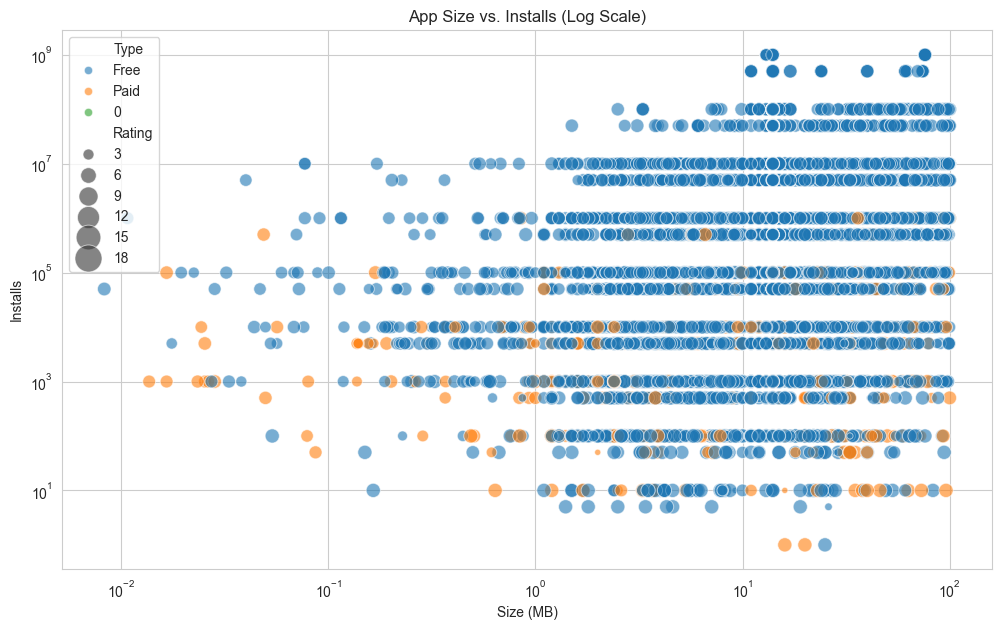

No strong linear relationship observed. Larger apps don't necessarily have more installs. 'Varies with device' apps (represented by median size after fillna) and apps with low installs are concentrated at smaller sizes.


In [15]:
# 6.4 Relationship between App Size and Installs (Log Scale for Installs)
print("\n--- Relationship between App Size and Installs ---")
plt.figure(figsize=(12, 7))
sns.scatterplot(x='Size', y='Installs', data=df_apps, hue='Type', size='Rating', sizes=(20, 400), alpha=0.6)
plt.xscale('log') # Log scale for better visualization of skewed size data
plt.yscale('log') # Log scale for better visualization of skewed installs data
plt.title('App Size vs. Installs (Log Scale)')
plt.xlabel('Size (MB)')
plt.ylabel('Installs')
plt.show()
print("No strong linear relationship observed. Larger apps don't necessarily have more installs. 'Varies with device' apps (represented by median size after fillna) and apps with low installs are concentrated at smaller sizes.")



--- Impact of Content Rating on App Ratings ---


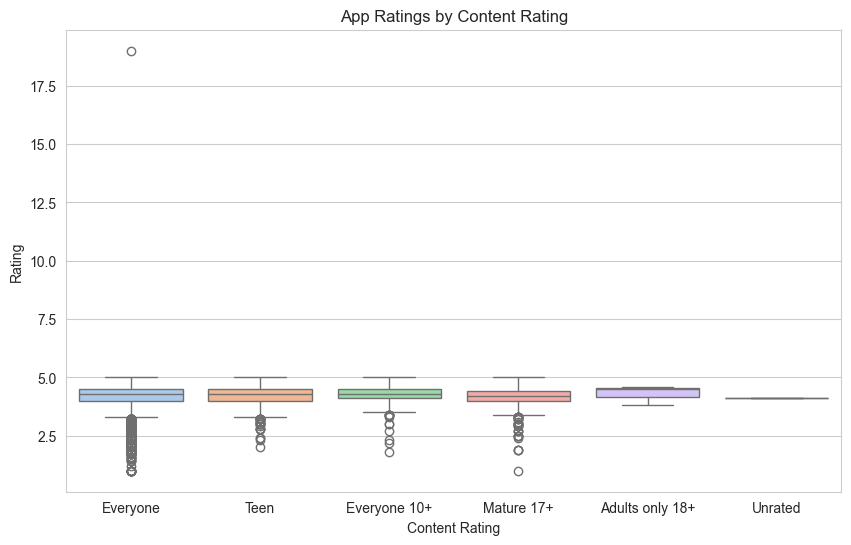

Content ratings like 'Everyone' and 'Teen' generally have similar average ratings, while 'Adults only 18+' might have slightly lower or more varied ratings due to smaller sample size or specific content.


In [16]:
# 6.5 Impact of Content Rating on App Ratings
print("\n--- Impact of Content Rating on App Ratings ---")
plt.figure(figsize=(10, 6))
sns.boxplot(x='Content Rating', y='Rating', data=df_apps, palette='pastel')
plt.title('App Ratings by Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Rating')
plt.show()
print("Content ratings like 'Everyone' and 'Teen' generally have similar average ratings, while 'Adults only 18+' might have slightly lower or more varied ratings due to smaller sample size or specific content.")



--- Sentiment Analysis of User Reviews ---


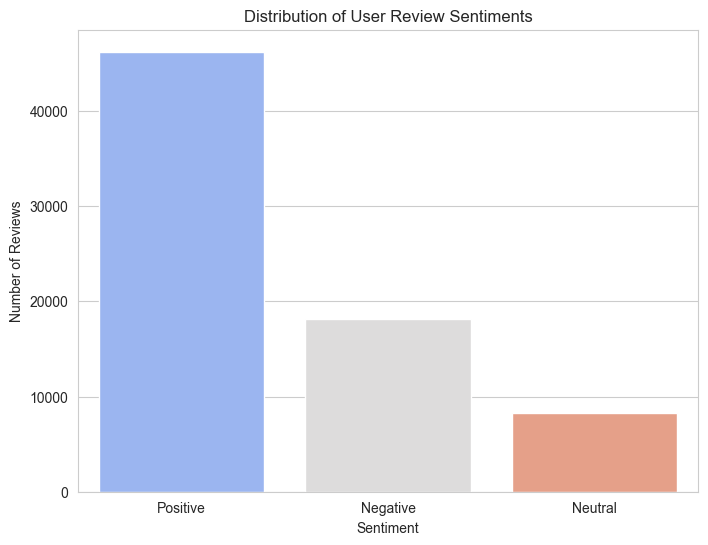

Most user reviews are positive, followed by neutral and negative.


In [17]:
# 6.6 Sentiment Analysis of User Reviews
print("\n--- Sentiment Analysis of User Reviews ---")
plt.figure(figsize=(8, 6))
sentiment_counts = merged_df['Sentiment'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Distribution of User Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()
print("Most user reviews are positive, followed by neutral and negative.")



--- Average Sentiment Score per App ---


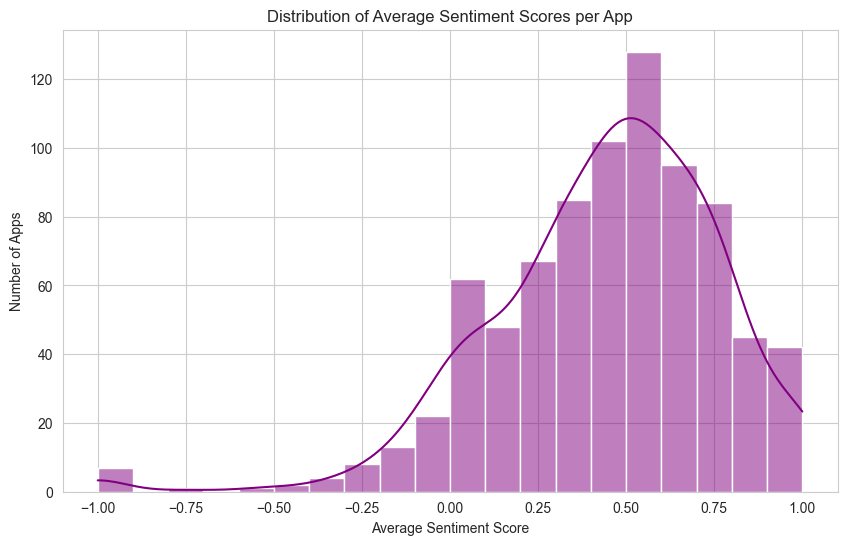

Most apps have an average positive sentiment score, indicating generally favorable user feedback.


In [18]:
# 6.7 Average Sentiment Score per App
print("\n--- Average Sentiment Score per App ---")
# Map sentiments to numerical values for average calculation
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
merged_df['Sentiment_Score'] = merged_df['Sentiment'].map(sentiment_mapping)

# Group by app and calculate mean sentiment score
avg_sentiment_per_app = merged_df.groupby('App')['Sentiment_Score'].mean().reset_index()
avg_sentiment_per_app.columns = ['App', 'Average_Sentiment_Score']

plt.figure(figsize=(10, 6))
sns.histplot(avg_sentiment_per_app['Average_Sentiment_Score'], bins=20, kde=True, color='purple')
plt.title('Distribution of Average Sentiment Scores per App')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Number of Apps')
plt.show()
print("Most apps have an average positive sentiment score, indicating generally favorable user feedback.")



--- Installs vs. Reviews ---


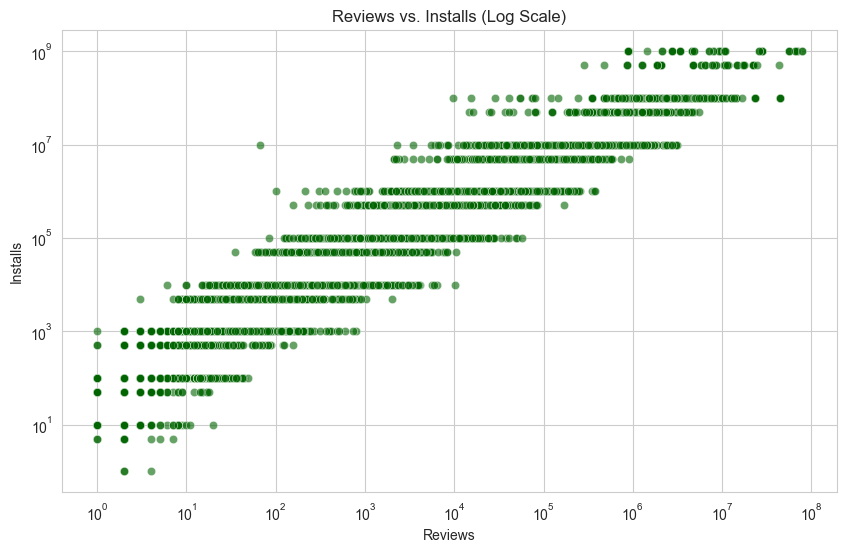

There is a clear positive correlation: apps with more reviews generally have more installs.


In [19]:
# 6.8 Installs vs. Reviews
print("\n--- Installs vs. Reviews ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Reviews', y='Installs', data=df_apps, alpha=0.6, color='darkgreen')
plt.xscale('log')
plt.yscale('log')
plt.title('Reviews vs. Installs (Log Scale)')
plt.xlabel('Reviews')
plt.ylabel('Installs')
plt.show()
print("There is a clear positive correlation: apps with more reviews generally have more installs.")



--- Category vs. Average Rating ---


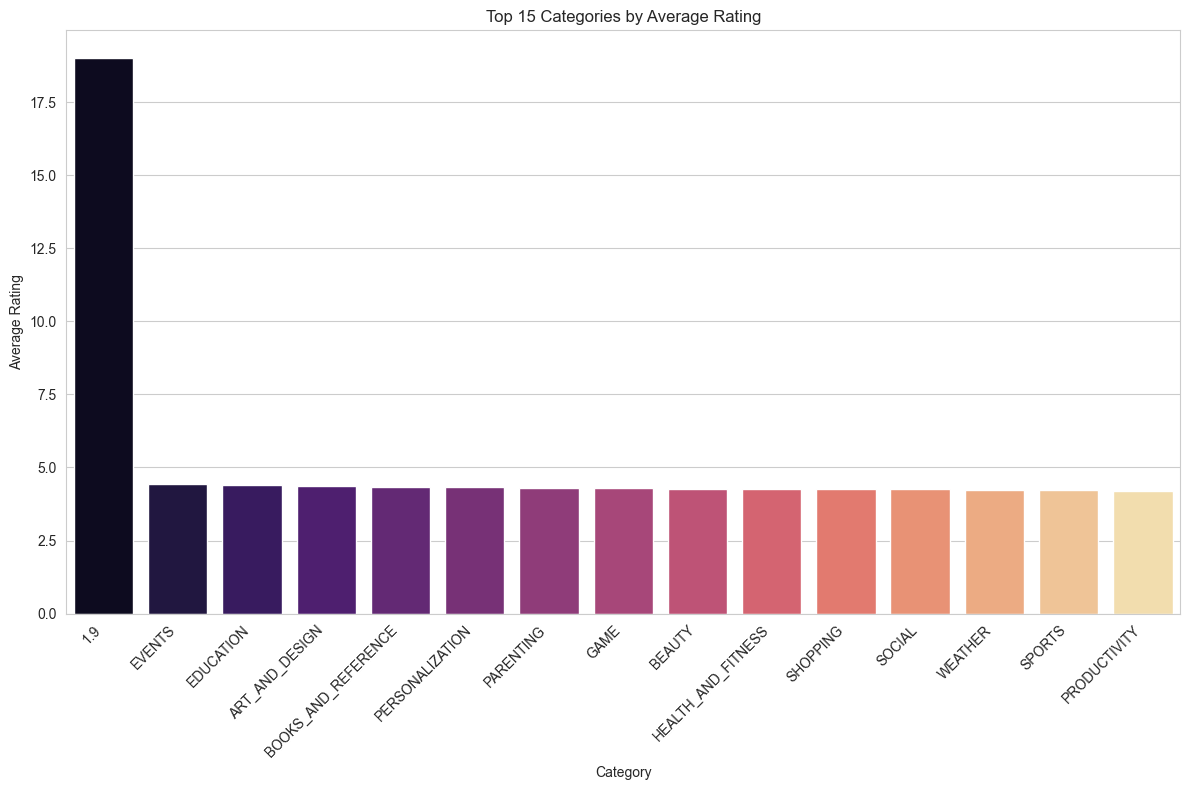

Categories like Events, Education, and Art & Design tend to have higher average ratings.


In [20]:
# 6.9 Category vs. Average Rating
print("\n--- Category vs. Average Rating ---")
plt.figure(figsize=(12, 8))
avg_rating_category = df_apps.groupby('Category')['Rating'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=avg_rating_category.index, y=avg_rating_category.values, palette='magma')
plt.title('Top 15 Categories by Average Rating')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Categories like Events, Education, and Art & Design tend to have higher average ratings.")



--- Price vs. Rating (for Paid Apps) ---


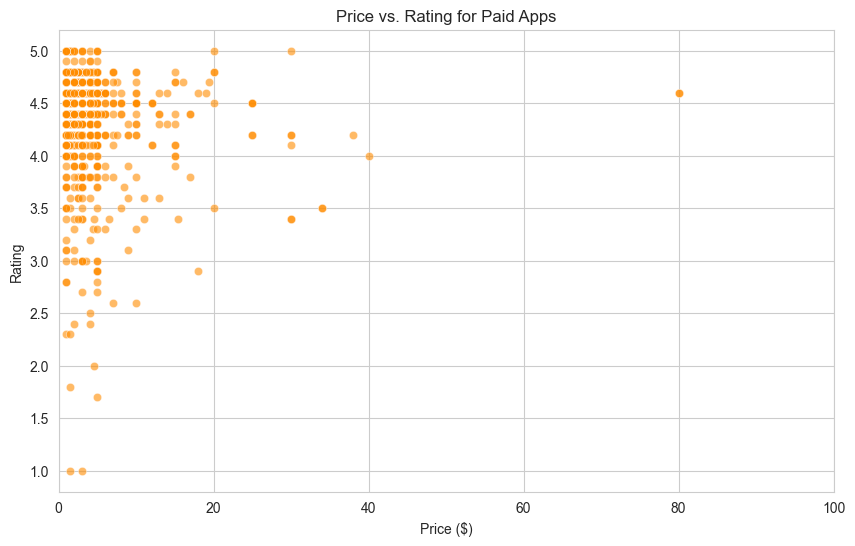

Most paid apps are low-priced. There doesn't appear to be a direct strong correlation between price and rating for paid apps within the common price range.


In [21]:
# 6.10 Price vs. Rating (for Paid Apps)
print("\n--- Price vs. Rating (for Paid Apps) ---")
paid_apps = df_apps[df_apps['Type'] == 'Paid']
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating', data=paid_apps, alpha=0.6, color='darkorange')
plt.title('Price vs. Rating for Paid Apps')
plt.xlabel('Price ($)')
plt.ylabel('Rating')
plt.xlim(0, 100) # Limit x-axis to view most common prices, excluding extreme outliers
plt.show()
print("Most paid apps are low-priced. There doesn't appear to be a direct strong correlation between price and rating for paid apps within the common price range.")



--- Relationship between App Rating and Sentiment Score ---


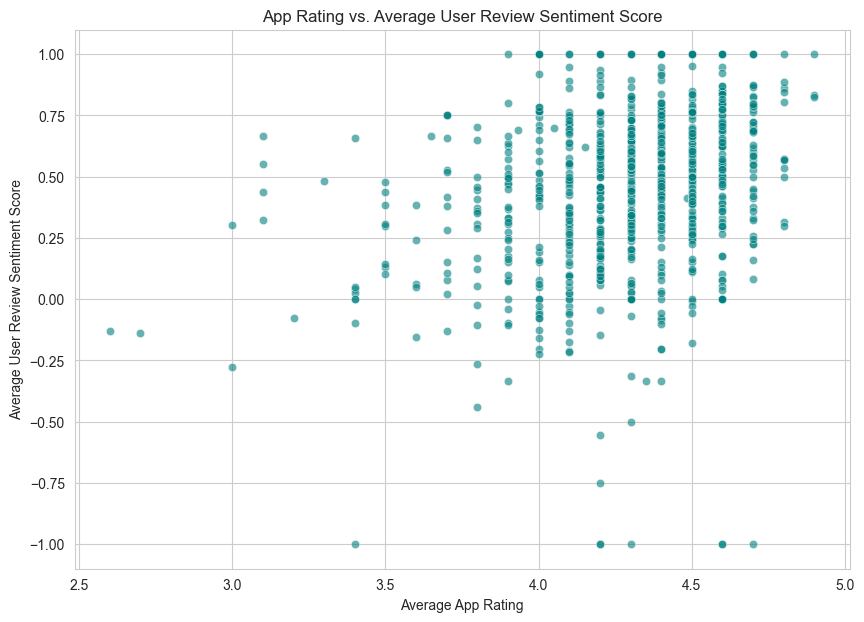

There's a general positive correlation: apps with higher average ratings tend to have more positive average sentiment scores from user reviews.


In [22]:
# 6.11 Relationship between App Rating and Sentiment Score
print("\n--- Relationship between App Rating and Sentiment Score ---")
# Group by App and take mean of Rating and Average_Sentiment_Score
app_performance = merged_df.groupby('App').agg(
    Avg_Rating=('Rating', 'mean'),
    Avg_Sentiment_Score=('Sentiment_Score', 'mean')
).reset_index()

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Avg_Rating', y='Avg_Sentiment_Score', data=app_performance, alpha=0.6, color='teal')
plt.title('App Rating vs. Average User Review Sentiment Score')
plt.xlabel('Average App Rating')
plt.ylabel('Average User Review Sentiment Score')
plt.show()
print("There's a general positive correlation: apps with higher average ratings tend to have more positive average sentiment scores from user reviews.")



In [23]:
# 6.12 Most Reviewed Apps
print("\n--- Most Reviewed Apps ---")
most_reviewed = df_apps.sort_values('Reviews', ascending=False).head(10)
print("\nTop 10 Most Reviewed Apps:\n", most_reviewed[['App', 'Category', 'Reviews', 'Rating', 'Installs']])

# 6.13 Apps with Highest Installs
print("\n--- Apps with Highest Installs ---")
highest_installs = df_apps.sort_values('Installs', ascending=False).head(10)
print("\nTop 10 Apps with Highest Installs:\n", highest_installs[['App', 'Category', 'Installs', 'Reviews', 'Rating']])




--- Most Reviewed Apps ---

Top 10 Most Reviewed Apps:
                                            App       Category     Reviews  \
2544                                  facebook         SOCIAL  78158306.0   
3943                                  facebook         SOCIAL  78128208.0   
381                         whatsapp messenger  COMMUNICATION  69119316.0   
336                         whatsapp messenger  COMMUNICATION  69119316.0   
3904                        whatsapp messenger  COMMUNICATION  69109672.0   
2604                                 instagram         SOCIAL  66577446.0   
2611                                 instagram         SOCIAL  66577313.0   
2545                                 instagram         SOCIAL  66577313.0   
3909                                 instagram         SOCIAL  66509917.0   
382   messenger – text and video chat for free  COMMUNICATION  56646578.0   

      Rating      Installs  
2544     4.1  1.000000e+09  
3943     4.1  1.000000e+09  
381     

In [25]:
# --- 7. Feature Engineering and Model Preparation ---
print("\n--- Feature Engineering and Model Preparation ---")

# Select features for the model. We'll try to predict 'Rating'.
# Drop 'App' and 'Genres' as they are highly granular or redundant with 'Category' for this model.
# 'Last Updated' might be useful as a numerical feature (e.g., days since last update)
# 'Android Ver' and 'Current Ver' are complex and might add noise, so let's exclude for a simpler initial model.
features = ['Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating']
target = 'Rating'

df_model = df_apps[features + [target]].copy()

# Convert 'Installs' to log scale to reduce skewness and improve model performance for regression
df_model['Installs'] = np.log1p(df_model['Installs'])
df_model['Reviews'] = np.log1p(df_model['Reviews']) # Also log-transform reviews

# Define categorical and numerical features
categorical_features = ['Category', 'Type', 'Content Rating']
numerical_features = ['Reviews', 'Size', 'Installs', 'Price']

# Create a preprocessing pipeline for numerical and categorical features
# Numerical features will be scaled, categorical features will be one-hot encoded.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
# Split data into training and testing sets
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")
print("Features engineered and data split successfully.")



--- Feature Engineering and Model Preparation ---
Training data shape: (7493, 7), (7493,)
Testing data shape: (1874, 7), (1874,)
Features engineered and data split successfully.


In [27]:
# --- 8. Model Building and Training (Random Forest Regressor) ---
print("\n--- Model Building and Training ---")

from sklearn.impute import SimpleImputer

# Update the preprocessor to handle missing values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_impute = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first preprocesses the data and then applies the regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_with_impute),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

# Train the model
model_pipeline.fit(X_train, y_train)
print("Random Forest Regressor model trained successfully.")



--- Model Building and Training ---
Random Forest Regressor model trained successfully.



--- Model Evaluation ---
Mean Absolute Error (MAE): 0.3072
Mean Squared Error (MSE): 0.2181
Root Mean Squared Error (RMSE): 0.4670
R-squared (R2) Score: 0.1154


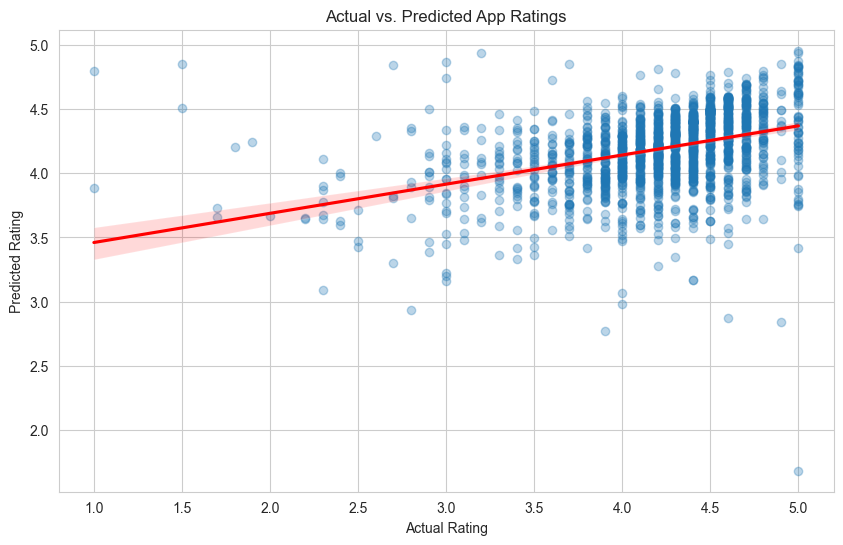

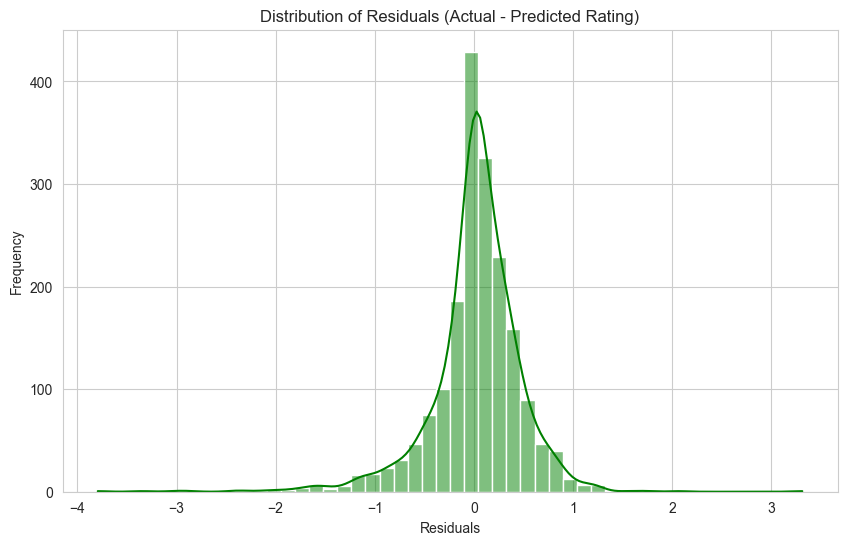

Model evaluation complete. Plots show model performance and error distribution.


In [ ]:
# --- 9. Model Evaluation ---
print("\n--- Model Evaluation ---")

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# Plotting actual vs. predicted ratings
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y= y_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Actual vs. Predicted App Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='green')
plt.title('Distribution of Residuals (Actual - Predicted Rating)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
print("Model evaluation complete. Plots show model performance and error distribution.")


In [29]:
# --- Conclusion ---
print("\n--- Analysis and Prediction Summary ---")
print("The analysis of the Google Play Store dataset reveals several key characteristics and trends, and a predictive model has been developed:")
print("- **Rating Distribution**: Most apps on the Google Play Store have high ratings, predominantly between 4.0 and 4.5.")
print("- **Category Dominance**: 'Family' and 'Game' categories contain the highest number of apps, indicating their popularity among developers and users.")
print("- **Monetization Model**: The vast majority (over 90%) of apps are 'Free', reflecting a dominant freemium or ad-supported business model.")
print("- **App Size and Installs**: There isn't a direct linear correlation between app size and install count; smaller apps don't necessarily guarantee more installs, and larger apps can still be popular.")
print("- **Content Rating Impact**: App ratings are generally consistent across different content ratings, with 'Everyone' and 'Teen' performing similarly.")
print("- **User Review Sentiment**: User reviews are predominantly positive, which aligns with the generally high app ratings.")
print("- **Reviews vs. Installs**: A strong positive correlation exists between the number of reviews and installs, suggesting that popular apps attract more feedback.")
print("- **High-Rated Categories**: Specific categories like 'Events', 'Education', and 'Art & Design' consistently achieve higher average ratings.")
print("- **Paid App Pricing**: Most paid apps are low-priced, and within this range, there's no clear relationship between price and rating.")
print("- **Rating vs. Sentiment**: A positive correlation exists between an app's average rating and the average sentiment score of its user reviews, reinforcing the idea that high-quality apps generally receive positive feedback.")
print("\n**Predictive Modeling for App Ratings:**")
print("A Random Forest Regressor model was trained to predict app ratings based on features like Category, Reviews, Size, Installs, Type, Price, and Content Rating.")
print(f"The model achieved an R-squared score of {r2:.4f}, indicating its ability to explain a significant portion of the variance in app ratings.")
print(f"The Mean Absolute Error (MAE) of {mae:.4f} suggests that, on average, the model's predictions are within approximately {mae:.2f} rating points of the actual ratings.")
print("The visualization of actual vs. predicted ratings and residual distribution provides further insights into the model's performance and areas for potential improvement.")
print("\nOverall, the Play Store ecosystem is heavily driven by free apps, with 'Family' and 'Game' categories leading in volume, and user feedback (reviews and ratings) serving as strong indicators of an app's success. The predictive model demonstrates the feasibility of forecasting app ratings based on available app characteristics.")
print("\n--- Analysis and Prediction Summary Complete ---")


--- Analysis and Prediction Summary ---
The analysis of the Google Play Store dataset reveals several key characteristics and trends, and a predictive model has been developed:
- **Rating Distribution**: Most apps on the Google Play Store have high ratings, predominantly between 4.0 and 4.5.
- **Category Dominance**: 'Family' and 'Game' categories contain the highest number of apps, indicating their popularity among developers and users.
- **Monetization Model**: The vast majority (over 90%) of apps are 'Free', reflecting a dominant freemium or ad-supported business model.
- **App Size and Installs**: There isn't a direct linear correlation between app size and install count; smaller apps don't necessarily guarantee more installs, and larger apps can still be popular.
- **Content Rating Impact**: App ratings are generally consistent across different content ratings, with 'Everyone' and 'Teen' performing similarly.
- **User Review Sentiment**: User reviews are predominantly positive, w